<a href="https://colab.research.google.com/github/tamirespps/Pos_PUC-Rio_MVP/blob/main/MVP_ML%26A_Tamires_Silva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MVP: Machine Learning & Analytics

Autor: Tamires Pereira Pinto da Silva

Data: 28/09/2025

Matrícula: 4052025000958

Dataset: [Kaggle - Titanic](https://www.kaggle.com/competitions/titanic/data)

# 1. Escopo, objetivo e definição do problema

### 1.1 Apresentação do problema e objetivo

O naufrágio do navio Titanic em 1912 resultou em mais de 1500 mortes.

O objetivo deste MVP é construir um modelo de **previsão de sobrevivência dos passageiros do Titanic** com base em suas características individuais, como idade, sexo, classe da cabine e número de familiares a bordo.

### Contexto do Problema
O Titanic é um caso clássico de análise de dados tabulares com objetivo de **classificação binária**: prever se um passageiro sobreviveu (`1`) ou não (`0`). Apesar de ser um dataset histórico e acadêmico, ele permite demonstrar técnicas de pré-processamento, engenharia de features, tratamento de valores ausentes e comparação de modelos de machine learning.

### Tipo de Tarefa
- **Classificação binária**: `Survived` (0 = Não sobreviveu, 1 = Sobreviveu).

### Área de Aplicação
- **Dados tabulares**: análise de atributos pessoais e de viagem dos passageiros.
- Aplicação de técnicas de ML supervisionado para classificação.

### Valor para o Negócio/Usuário
- Permite compreender fatores que influenciam a sobrevivência de passageiros em situações críticas.
- Serve como referência pedagógica para o desenvolvimento de pipelines de ML, avaliação de modelos e técnicas de pré-processamento de dados desbalanceados.
- Demonstra comparações entre **modelos simples** (baseline) e **modelos mais complexos** (Random Forest, XGBoost, Logistic Regression), incluindo validação cruzada e holdout para avaliação robusta.


# 2. Reprodutibilidade e ambiente

In [1]:
# importacao dos dados do google drive
import gdown

# Manipulação de dados
import pandas as pd
import numpy as np
import random

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e engenharia de atributos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Modelagem
from sklearn.dummy import DummyClassifier #baseline
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Avaliação
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, ConfusionMatrixDisplay

# Otimização de hiperparâmetros
from sklearn.model_selection import StratifiedKFold,GridSearchCV, cross_val_predict, cross_val_score

# Boas práticas
import time
import sys
import warnings
warnings.filterwarnings('ignore')

SEED = 42  # seed fixa para reprodutibilidade

random.seed(SEED)
np.random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


In [2]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

#3.Dados: carga, entendimento e qualidade

## Contexto do dataset


O dataset contém informações sobre 891 passageiros, com a variável alvo "Survived":
- 0 = não sobreviveu
- 1 = sobreviveu


O dataset está disponível no Kaggle, mas para este mvp foi carregado no Google Drive, podendo ser acessado através do link:

[Link do dataset no Google Drive](https://drive.google.com/drive/folders/10_iItLwCXlLxBLsNXyzph1_Y5hu-yX4E?usp=sharing)



### Dicionário dos Dados

- PassengerId – Identificador único de cada passageiro no dataset (um número sequencial).

- Survived – Indicador de sobrevivência (variável alvo):

    0 = Não sobreviveu

    1 = Sobreviveu

- Pclass – Classe do bilhete (reflete status socioeconômico):

    1 = Primeira classe (alta)

    2 = Segunda classe (média)

    3 = Terceira classe (baixa)

- Name – Nome completo do passageiro (inclui título, como Mr., Mrs., Miss., Master, etc.).

- Sex – Sexo do passageiro (male = masculino, female = feminino).

- Age – Idade em anos (pode conter valores nulos).

- SibSp – Número de irmãos ou cônjuges a bordo do Titanic.

- Parch – Número de pais ou filhos a bordo do Titanic.

- Ticket – Número do bilhete de passagem (pode ter repetições).

- Fare – Tarifa paga pelo bilhete.

- Cabin – Número da cabine (quando disponível).

- Embarked – Porto de embarque:

    C = Cherbourg

    Q = Queenstown

    S = Southampton

## 3.1 Carregamento dos Dados


In [3]:
gdown.download('https://drive.google.com/uc?id=1CTkFD5-78xlxlvILNaBhH5scgdTU2TUM', 'train.csv', quiet=False)

df_origin = pd.read_csv('train.csv')
df = df_origin.copy()
df.head(2)

Downloading...
From: https://drive.google.com/uc?id=1CTkFD5-78xlxlvILNaBhH5scgdTU2TUM
To: /content/train.csv
100%|██████████| 61.2k/61.2k [00:00<00:00, 47.0MB/s]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## 3.2 Análise exploratória resumida (EDA)
Nesta seção é realizado uma análise exploratória inicial no Dataset do Titanic, incluindo:

- Verificação de valores ausentes

- Distribuição da variável alvo (Survived)

- Informações gerais sobre os dados

- Análise de sobrevivência por sexo, idade e classe

- Correlação das variáveis

###3.2.1 Informações iniciais

In [4]:
# === Verificações iniciais ===
display(df.sample(5))
print("Dimensão do dataset:", df.shape)
print("\nInformações gerais:")
print(df.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


Dimensão do dataset: (891, 12)

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


###3.2.2 Percentual de valores ausentes


Valores ausentes por coluna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


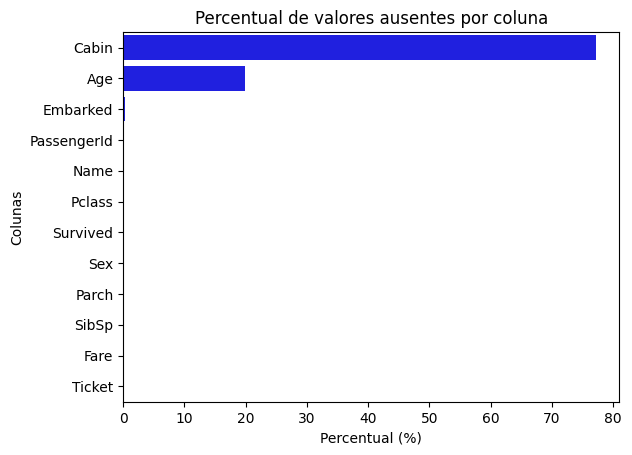

In [5]:
print("\nValores ausentes por coluna:")
print(df.isna().sum())

missing_percent = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)


sns.barplot(x=missing_percent, y=missing_percent.index, color="blue")
plt.title("Percentual de valores ausentes por coluna")
plt.xlabel("Percentual (%)")
plt.ylabel("Colunas")
plt.show()

### 3.2.3 Distribuição da variável alvo (Survived)

Survived
0    549
1    342
Name: count, dtype: int64
Percentuais:
 Survived
0    61.616162
1    38.383838
Name: count, dtype: float64


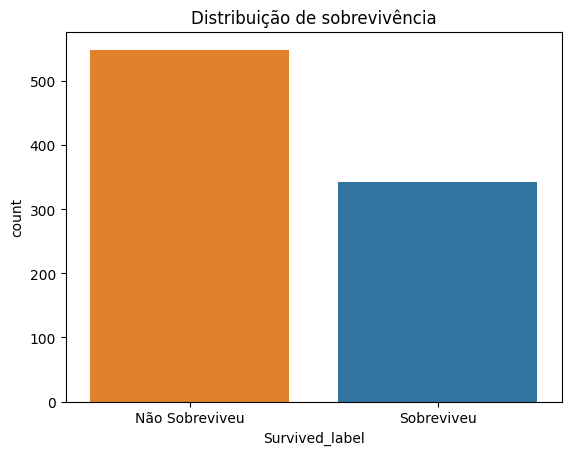

In [6]:
survived_counts = df['Survived'].value_counts()
print(survived_counts)
print("Percentuais:\n", (survived_counts/len(df))*100)

#Mapeando valores para rotulos descritivos
df['Survived_label'] = df['Survived'].map({0: "Não Sobreviveu", 1: "Sobreviveu"})

# Definir cores: laranja para Não Sobreviveu, azul para Sobreviveu
colors = {'Não Sobreviveu': '#ff7f0e', 'Sobreviveu': '#1f77b4'}

sns.countplot(x="Survived_label", data=df, palette=colors)
plt.title("Distribuição de sobrevivência")
plt.show()

### 3.2.4 Análise por Sexo

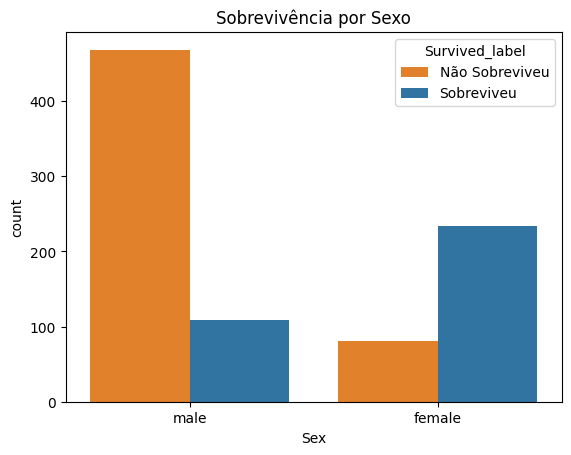

Taxa de sobrevivência por sexo:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [7]:
sns.countplot(data=df, x="Sex", hue="Survived_label", palette=colors)
plt.title("Sobrevivência por Sexo")
plt.show()

print("Taxa de sobrevivência por sexo:")
print(df.groupby("Sex")["Survived"].mean())


### 3.2.5 Análise por Classe

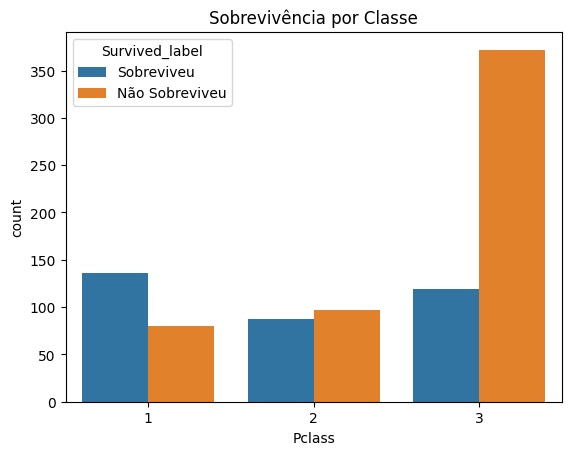

Taxa de sobrevivência por classe:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [8]:
sns.countplot(data=df, x="Pclass", hue="Survived_label", palette=colors)
plt.title("Sobrevivência por Classe")
plt.show()

print("Taxa de sobrevivência por classe:")
print(df.groupby("Pclass")["Survived"].mean())


### 3.2.6 Sobrevivência por Sexo + Classe

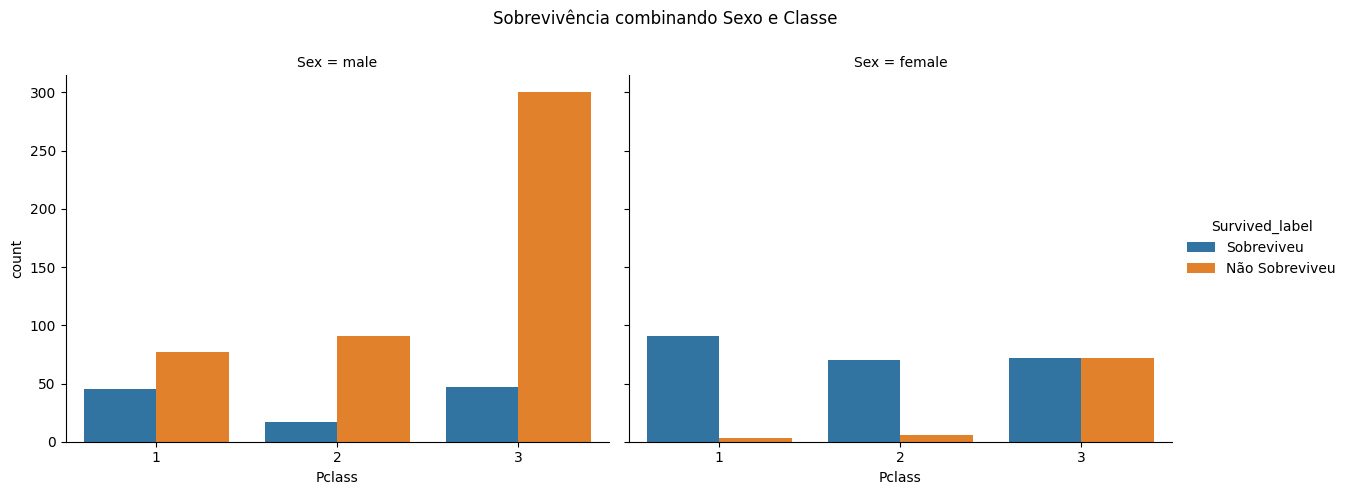

In [9]:
sns.catplot(data=df, x="Pclass", hue="Survived_label", col="Sex",
            kind="count", height=5, aspect=1.2, palette=colors)
plt.subplots_adjust(top=0.85)
plt.suptitle("Sobrevivência combinando Sexo e Classe")
plt.show()


### 3.2.7 Distribuição da classe sobrevivência por Idade

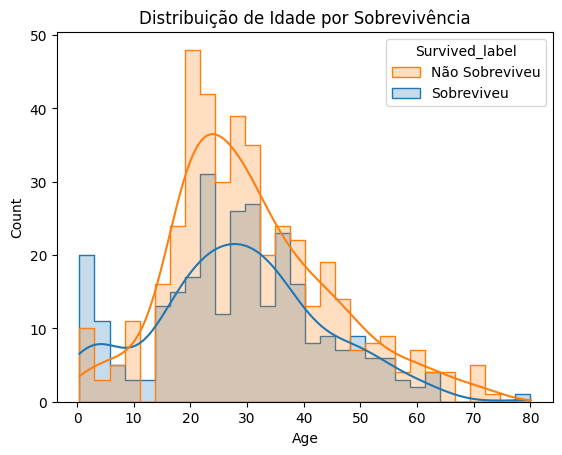

Resumo de idade por sobrevivência:
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0


In [10]:
sns.histplot(
    data=df, x="Age", bins=30, hue="Survived_label", kde=True, element="step",
    palette=colors)
plt.title("Distribuição de Idade por Sobrevivência")
plt.show()

print("Resumo de idade por sobrevivência:")
print(df.groupby("Survived")["Age"].describe())


### 3.2.8 Sobrevivência por Faixa Etária


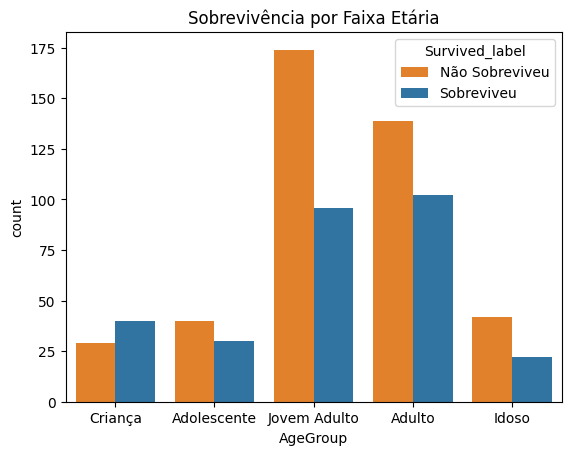

Taxa de sobrevivência por faixa etária:
AgeGroup
Criança         0.579710
Adolescente     0.428571
Jovem Adulto    0.355556
Adulto          0.423237
Idoso           0.343750
Name: Survived, dtype: float64


In [11]:
# Criando faixas de idade
df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 80],
                        labels=["Criança", "Adolescente", "Jovem Adulto", "Adulto", "Idoso"])

sns.countplot(data=df, x="AgeGroup", hue="Survived_label", palette=colors)
plt.title("Sobrevivência por Faixa Etária")
plt.show()

print("Taxa de sobrevivência por faixa etária:")
print(df.groupby("AgeGroup")["Survived"].mean())


###3.2.9 Sobrevicência por faixa etária, sexo e classe

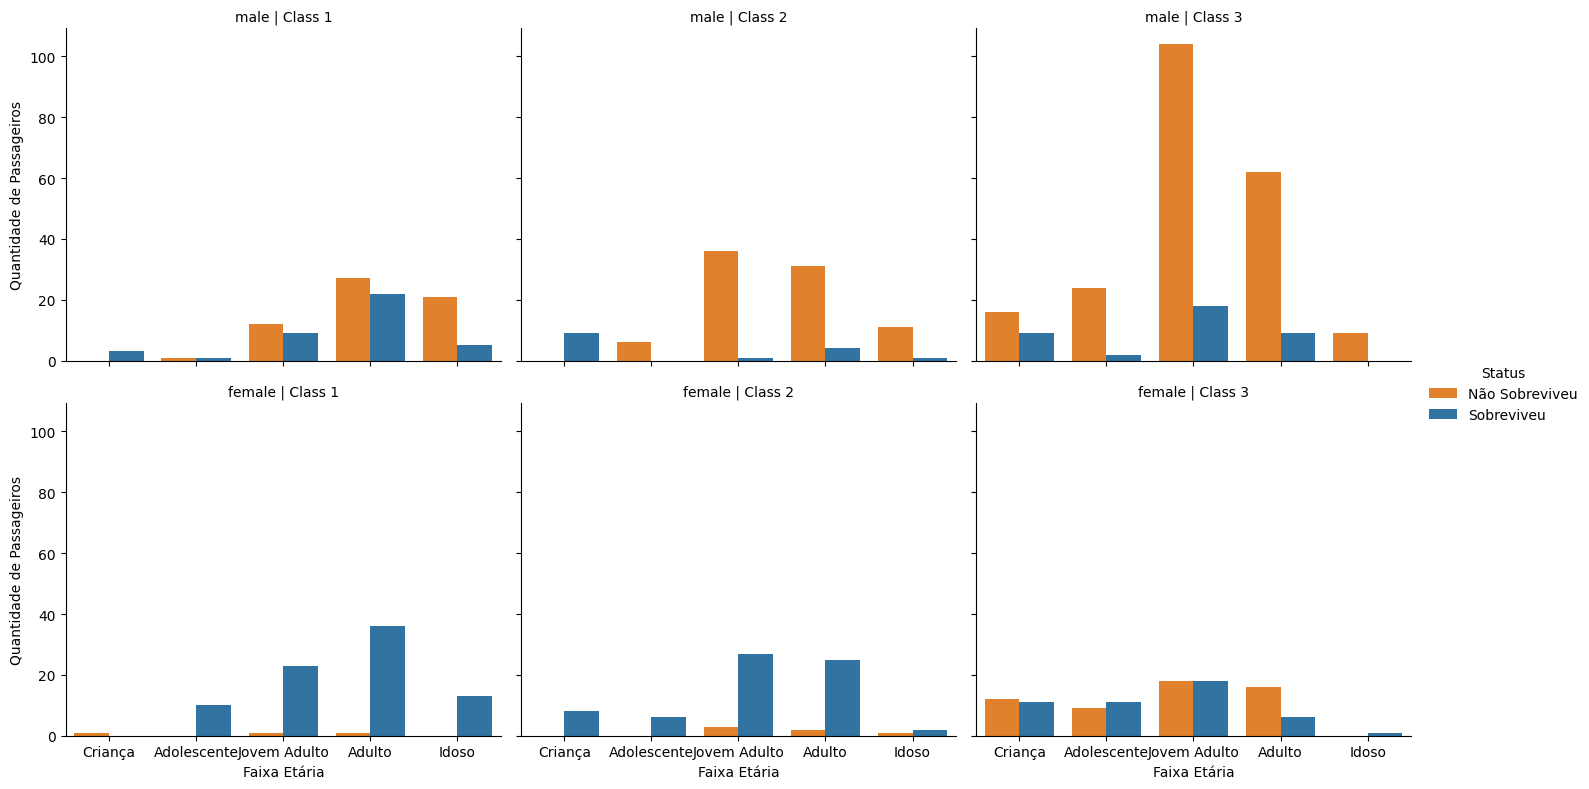

In [12]:
# FacetGrid por Sexo e Pclass
g = sns.catplot(
    data=df,
    x="AgeGroup",
    hue="Survived_label",
    col="Pclass",      # colunas do grid = classes do Titanic
    row="Sex",         # linhas do grid = sexo
    kind="count",
    palette=colors,
    height=4,
    aspect=1.2
)

g.set_axis_labels("Faixa Etária", "Quantidade de Passageiros")
g.set_titles("{row_name} | Class {col_name}")
g._legend.set_title("Status")
plt.show()


###3.2.10 Matriz de Correlação das Variáveis

Correlação das variáveis com Survived:
Survived       1.000000
Sex            0.536762
Fare           0.266100
Embarked       0.108517
Parch          0.095265
PassengerId    0.029526
SibSp         -0.015523
Age           -0.082446
Pclass        -0.356462
Name: Survived, dtype: float64


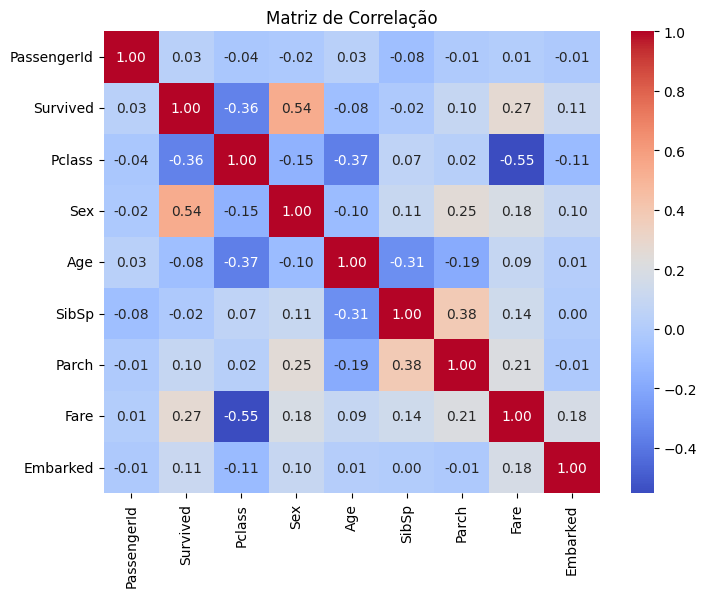

In [13]:
# Copiar dataset e converter variáveis categóricas em numéricas
df_corr = df.copy()
df_corr = df_corr.dropna(subset=['Embarked'])
df_corr = df_corr.dropna(subset=['Age'])

# Mapear variáveis categóricas simples
df_corr["Sex"] = df_corr["Sex"].map({"male": 0, "female": 1})
df_corr["Embarked"] = df_corr["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Calcular correlação com Survived
correlation = df_corr.corr(numeric_only=True)["Survived"].sort_values(ascending=False)

print("Correlação das variáveis com Survived:")
print(correlation)

# Visualização em heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()



## 3.3 Insights sobre a análise dos dados do Titanic


1. O dataset possui valores ausentes relevantes em Cabin (\~77%), Age (\~19%) e Embarked (\<1%).
2. A variável alvo (Survived) está desbalanceada: 62% não sobreviveram vs. 38% sobreviveram.
3. Mulheres sobreviveram em muito maior proporção que homens (~74% contra ~19%).
4. Passageiros da 1ª classe tiveram muito mais chances de sobreviver do que os da 3ª classe.
5. Crianças e jovens tiveram taxas de sobrevivência mais altas.
6. Sexo, Tarifa, Classe e Idade são fortes candidatos a features importantes para modelagem.



# 4. Definição do target, variáveis e divisão dos dados

##4.1 Remoção das 2 linhas sem os dados de local de embarque

O conjunto de dados df_origin será dividido em dois datasets:
- df_missing_embarked -> só os passageiros sem valor em Embarked.

- df_embarked -> dados limpos quanto a Embarked, prontos para análise e modelagem.

In [14]:
# Separar registros com Embarked ausente
df_missing_embarked = df_origin[df_origin['Embarked'].isna()].copy()

# Separar registros com Embarked preenchido
df_embarked = df_origin[df_origin['Embarked'].notna()].copy()

# Conferir quantos registros estão em cada subset
print("Registros com Embarked ausente:", len(df_missing_embarked))
print("Registros com Embarked preenchido:", len(df_embarked))

Registros com Embarked ausente: 2
Registros com Embarked preenchido: 889


##4.2 Separando variáveis e alvo


In [15]:
X = df_embarked.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df_embarked['Survived']

num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Pclass', 'Sex', 'Embarked']

##4.3 Divisão do conjunto de treino e teste (hould out)
A partir do dataset df_embarked será realizada a divisão dos dados de treino e de teste.

In [16]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 5. Tratamento de dados e **Pipeline** de pré-processamento

##5.1 Verificando percentual de valores ausentes no treino e no teste(holdout)

In [17]:
missing_percent_train = ((X_train.isnull().sum() / len(X_train)) * 100).sort_values(ascending=False)
missing_percent_holdout = ((X_holdout.isnull().sum() / len(X_holdout)) * 100).sort_values(ascending=False)
print(f'% Valores ausentes no dataset de treino: \n {missing_percent_train} \n% Valores ausentes no dataset de teste (holdout): \n{missing_percent_holdout}')

% Valores ausentes no dataset de treino: 
 Age         19.690577
Pclass       0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.000000
dtype: float64 
% Valores ausentes no dataset de teste (holdout): 
Age         20.786517
Pclass       0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.000000
dtype: float64


##5.2 Transformer customizado para calcular a faixa etária de cada passageiro com base na idade e incluir o preenchimento dos valores ausentes da faixa etária

In [18]:
class AgeGroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=SEED):
        self.random_state = random_state
        self.model = RandomForestClassifier(
            n_estimators=100, random_state=random_state
        )
        self.features_age = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"]

    def fit(self, X, y=None):
        X_ = X.copy()
        # Criar AgeGroup
        X_["AgeGroup"] = pd.cut(
            X_["Age"],
            bins=[0, 12, 18, 30, 50, 80],
            labels=["Crianca", "Adolescente", "Jovem Adulto", "Adulto", "Idoso"]
        )
        # Treinar modelo só nos registros com AgeGroup conhecido
        known = X_.dropna(subset=["AgeGroup"])
        X_train = pd.get_dummies(known[self.features_age], drop_first=True)
        y_train = known["AgeGroup"]
        self.model.fit(X_train, y_train)
        self.columns_ = X_train.columns
        return self

    def transform(self, X):
        X_ = X.copy()
        # Criar AgeGroup inicial
        X_["AgeGroup"] = pd.cut(
            X_["Age"],
            bins=[0, 12, 18, 30, 50, 80],
            labels=["Crianca", "Adolescente", "Jovem Adulto", "Adulto", "Idoso"]
        )
        # Prever onde AgeGroup é nulo
        missing = X_[X_["AgeGroup"].isna()]
        if not missing.empty:
            X_missing = pd.get_dummies(missing[self.features_age], drop_first=True)
            X_missing = X_missing.reindex(columns=self.columns_, fill_value=0)
            preds = self.model.predict(X_missing)
            X_.loc[X_["AgeGroup"].isna(), "AgeGroup"] = preds
        return X_

##5.3 Pré-processamento das variáveis

In [19]:
# Features numéricas e categóricas
num_features = ['Fare', 'SibSp', 'Parch']
cat_features = ['Pclass', 'Sex', 'Embarked', 'AgeGroup']

# Transformadores
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pré-processador final
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# 6. Modelo Baseline e modelos candidatos (comparação dos resultados)

## 6.1 Modelo Baseline (aleatório)
Para o Baseline, vamos utilizar uma estratégia aleatória. Como lançar uma moeda de cara ou coroa para definir se um passageiro irá sobreviver ou não.

In [20]:
# Baseline com DummyClassifier
baseline = Pipeline(steps=[
    ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
    ("pre", preprocessor),  # se quiser aplicar preprocessamento
    ("model", DummyClassifier(strategy="uniform", random_state=SEED))  # 'uniform' = sorteio aleatório
])

## 6.2 Modelos candidatos
Vamos experimentar 3 modelos para a predição da sobrevivência que são:
- Regressão logistíca
- Random Forest
- XGboost

In [21]:
models = {
    "XGBoost": Pipeline([
        ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=SEED,
            scale_pos_weight=sum(y_train==0)/sum(y_train==1)
        ))
    ]),

    "RandomForest": Pipeline([
        ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),

    "LogisticRegression": Pipeline([
        ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            random_state=SEED,
            class_weight="balanced"
        ))
    ])
}


## 6.3 Treino e avaliação rápida (baseline vs candidatos)

In [22]:
results = {}

# Baseline
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_holdout)
proba = baseline.predict_proba(X_holdout) if hasattr(baseline, "predict_proba") else None
results["baseline"] = evaluate_classification(y_holdout, y_pred, proba)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Candidatos
for name, pipe in models.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_holdout)
    proba = pipe.predict_proba(X_holdout) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_holdout, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T

,accuracy,f1_weighted,roc_auc,train_time_s
baseline,0.460674,0.467813,0.500000,0.511
XGBoost,0.825843,0.825592,0.832553,0.681
RandomForest,0.814607,0.813763,0.823061,0.935
LogisticRegression,0.808989,0.809497,0.858155,0.690


#7. Modelagem, Otimização dos hiperparâmetros e Avaliação da performance

##7.2 Modelos de ML e hiperparâmetros para otimização

In [23]:
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             random_state=SEED, scale_pos_weight=sum(y_train==0)/sum(y_train==1)),
    'RandomForest': RandomForestClassifier(random_state=SEED, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')
}

param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__subsample': [0.8, 1],
        'classifier__colsample_bytree': [0.8, 1],
        'classifier__gamma': [0, 0.2],
        'classifier__scale_pos_weight': [np.sum(y_train==0)/np.sum(y_train==1)]
    }

}

##7.3 Treinar e avaliar modelos usando validação cruzada
- A métrica F1-score é utilizada por ser a métrica mais adequada para problemas com classes desbalanceadas, pois combina precisão (evitar falsos positivos) e recall (evitar falsos negativos).
- O uso da validação cruzada estratificada assegura que cada fold preserva a proporção entre as classes, tornando a avaliação mais justa e representativa.


In [24]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results = []
for name, model in models.items():
    print(f"\n Otimizando os hiperparâmetros do algoritmo: {name}")

    # Pipeline com imputação de AgeGroup + preprocessor + model
    pipeline = Pipeline(steps=[
        ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    # Avaliar com cross_val_score
    scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring="f1")

    results.append({
        "Modelo": name,
        "F1 Média": scores.mean(),
        "F1 Desvio": scores.std(),
        "Melhores Params": grid.best_params_
    })

df_results = pd.DataFrame(results).sort_values(by="F1 Média", ascending=False)

print("\n===== Comparação Final =====")
print(df_results)

best_model_name = df_results.iloc[0]["Modelo"]
best_params = df_results.iloc[0]["Melhores Params"]

print(f"\n Melhor modelo: {best_model_name}")
# print(f" Melhores hiperparâmetros: {best_params}")



 Otimizando os hiperparâmetros do algoritmo: XGBoost

 Otimizando os hiperparâmetros do algoritmo: RandomForest

 Otimizando os hiperparâmetros do algoritmo: LogisticRegression

===== Comparação Final =====
               Modelo  F1 Média  F1 Desvio  \
0             XGBoost  0.783780   0.016186   
1        RandomForest  0.755308   0.014889   
2  LogisticRegression  0.722459   0.031542   

                                     Melhores Params  
0  {'classifier__colsample_bytree': 1, 'classifie...  
1  {'classifier__max_depth': 10, 'classifier__min...  
2  {'classifier__C': 10, 'classifier__solver': 'l...  

 Melhor modelo: XGBoost


Na comparação dos três algoritmos otimizados testados (XGBoost, Random Forest e Regressão Logística), observamos que:

XGBoost apresentou a maior média de F1-score (0.784) com o menor desvio padrão (0.016), indicando não apenas melhor desempenho médio, mas também maior consistência entre os folds da validação cruzada.

## 7.4 Treinamento do melhor modelo

In [25]:
#Criando pipeline final com AgeGroupImputer + Preprocessor + XGBoost Tunado
best_model = Pipeline([
    ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(**best_params))
])


# Treino com marcação de tempo
t0 = time.time()
best_model.fit(X_train, y_train)
t1 = time.time()

print(f"Treino concluído em {t1 - t0:.2f} segundos.")

Treino concluído em 0.29 segundos.


# 8. Avaliações finais

## 8.1 Comparando a Matriz de confusão do Baseline com o Modelo no dataset de teste

              precision    recall  f1-score   support

           0       0.58      0.45      0.51       110
           1       0.35      0.49      0.41        68

    accuracy                           0.46       178
   macro avg       0.47      0.47      0.46       178
weighted avg       0.49      0.46      0.47       178



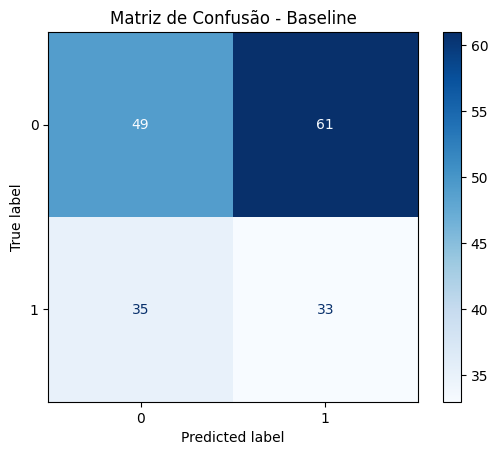


===== Avaliação Final (XGBoost) =====
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.74      0.76        68

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.83      0.82       178



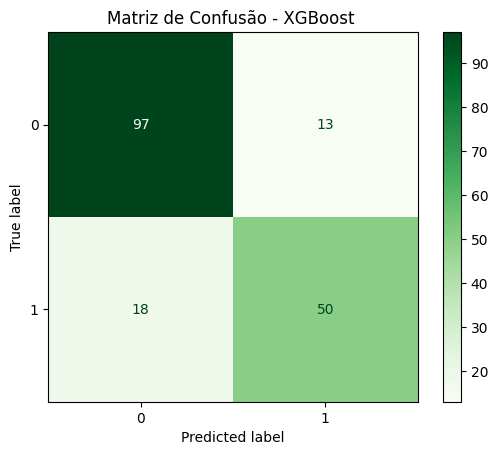

In [26]:
# Avaliação no Holdout do Baseline
baseline = Pipeline(steps=[
    ("agegroup_imputer", AgeGroupImputer(random_state=SEED)),
    ("pre", preprocessor),  # se quiser aplicar preprocessamento
    ("model", DummyClassifier(strategy="uniform", random_state=SEED))  # 'uniform' = sorteio aleatório
])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_holdout)
print(classification_report(y_holdout, y_pred_base))

cm_base = confusion_matrix(y_holdout, y_pred_base)
ConfusionMatrixDisplay(cm_base).plot(cmap="Blues")
plt.title("Matriz de Confusão - Baseline")
plt.show()

# Avaliação no Holdout do melhor modelo
y_pred_hold = best_model.predict(X_holdout)
y_proba_hold = best_model.predict_proba(X_holdout)[:, 1]

print("\n===== Avaliação Final (XGBoost) =====")
print(classification_report(y_holdout, y_pred_hold))

# Matriz de confusão
try:
    ConfusionMatrixDisplay.from_estimator(best_model, X_holdout, y_holdout, cmap="Greens")
    plt.title("Matriz de Confusão - XGBoost ")
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)

##8.2 Avaliando as previsões do Modelo por faixa etária

In [27]:
#Adicionando a coluna referente a faixa etária no holdout
age_imputer = AgeGroupImputer(random_state=SEED)
age_imputer.fit(X_train)  # Treinar o imputador com X_train
X_holdout_imputed = age_imputer.transform(X_holdout)

# Supondo que y_holdout e y_hold_pred sejam arrays ou Series
df_eval = X_holdout_imputed.copy()

# Coluna com as previsões
df_eval["y_pred"] = y_pred_hold

# Coluna indicando se o modelo acertou
df_eval["acertou"] = df_eval["y_pred"] == y_holdout

# Agora "acertou" é True quando o modelo acertou e False caso contrário
df_eval.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,y_pred,acertou
160,3,male,44.0,0,1,16.100,S,Adulto,0,True
126,3,male,NaN,0,0,7.750,Q,Idoso,0,True
428,3,male,NaN,0,0,7.750,Q,Idoso,0,True
422,3,male,29.0,0,0,7.875,S,Jovem Adulto,0,True
565,3,male,24.0,2,0,24.150,S,Jovem Adulto,0,True


In [28]:
# Agrupando por AgeGroup e calculando estatísticas
stats_agegroup = df_eval.groupby("AgeGroup").agg(
    total_passageiros=("acertou", "size"),
    acertos=("acertou", "sum"),
).reset_index()

# Calculando taxa de acerto
stats_agegroup["taxa_acerto"] = stats_agegroup["acertos"] / stats_agegroup["total_passageiros"]

stats_agegroup

,AgeGroup,total_passageiros,acertos,taxa_acerto
0,Crianca,18,15,0.833333
1,Adolescente,20,17,0.850000
2,Jovem Adulto,69,56,0.811594
3,Adulto,52,41,0.788462
4,Idoso,19,18,0.947368


## 8.3 Verificando o impacto do local de embarque
Alternando o valor do local de embarque nos 2 registros que foram removidas logo no começo.

Testando todas as opções de embarque para ver o resultado do modelo.

In [29]:
# Lista de possíveis valores
embarked_options = ["C", "Q", "S"]

# Criar um DataFrame para armazenar os resultados
predictions_list = []

for value in embarked_options:
    # Copiar apenas os registros ausentes
    X_missing_copy = df_missing_embarked.copy()

    # Preencher o valor faltante de Embarked
    X_missing_copy["Embarked"] = value

    # Prever usando o modelo treinado
    y_pred = best_model.predict(X_missing_copy)

    # Guardar resultados
    X_missing_copy["Embarked_scenario"] = value
    X_missing_copy["Survived_pred"] = y_pred
    predictions_list.append(X_missing_copy)

# Concatenar todos os cenários para os 2 registros
df_predictions_scenarios = pd.concat(predictions_list)
df_predictions_scenarios



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_scenario,Survived_pred
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,C,C,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,C,C,1
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,Q,Q,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,Q,Q,1
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,S,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,S,1


É possível ver que de fato, o local de embarque não é uma variavel com grande impacto na previsão de sobrevivência.

#9. Conclusões e Próximos Passos

### Conclusões
- O modelo XGBoost conseguiu aprender padrões relevantes para prever a sobrevivência dos passageiros, com alta taxa de acerto média, especialmente em faixas etárias como idosos (≈95%) e adolescentes (≈85%).
- Sexo, classe social e idade se mostraram determinantes para a previsão, destacando a importância de variáveis demográficas e sociais.
- Houve necessidade de **tratamento de valores ausentes** e padronização de algumas variáveis (ex.: `AgeGroup` e `StandardScaler`).
- E o tratamento de valores ausentes utilizando um modelo de ML e não um valor constante e a criação da variável AgeGroup foram essenciais para garantir qualidade dos dados.
- O pipeline estruturado assegura reprodutibilidade e facilidade de manutenção, permitindo ajustes futuros sem comprometer a robustez
- Para além da modelagem experimentada neste MVP, algumas análises socio-economicas são interessantes sobre os dados do Titanic, considerando as classes com mais sobreviventes e o sexo também.

### Trade-offs
- Optei por manter o pipeline simples (imputação + scaler), priorizando clareza sobre complexidade.
- A remoção de algumas features ou ajustes mais finos no pré-processamento pode impactar a performance do modelo, mas adicionaria mais custo computacional.
- Não foi explorado tuning exaustivo de hiperparâmetros, para manter o MVP ágil e interpretável.

### Próximos Passos
- **Melhoria de features**: criar variáveis derivadas (ex.: tamanho da família).
- **Testar novos algoritmos de classificação**.
- **Implantação**: salvar pipeline treinado e disponibilizar via API ou aplicação simples para consulta.
